In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [7]:
image_path = tf.keras.utils.get_file('Tabby_Cat.jpg', 'https://commons.wikimedia.org/wiki/Special:FilePath/Tabby_Cat.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1387165/1387165 ━━━━━━━━━━━━━━━━━━━━ 6s 4us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


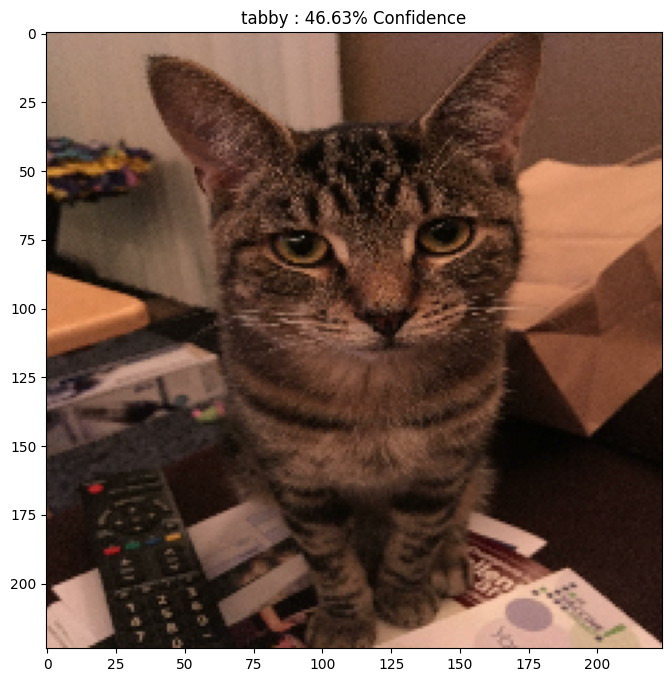

In [8]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

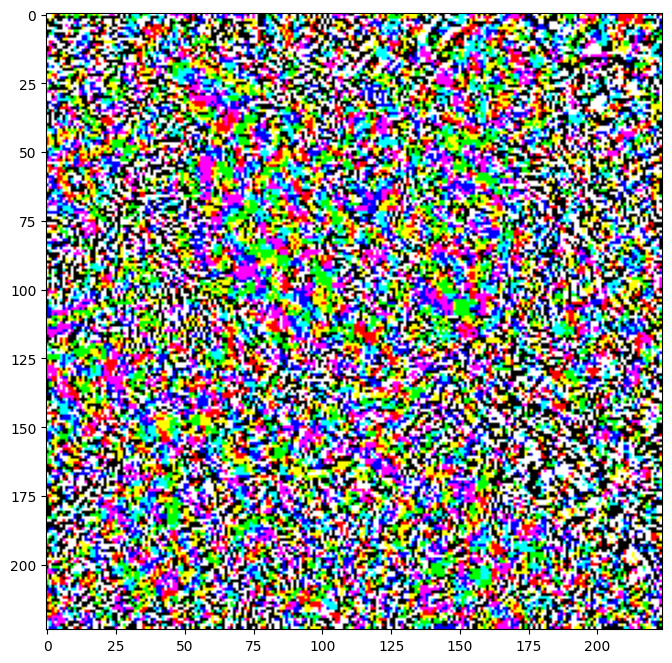

In [10]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [21]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


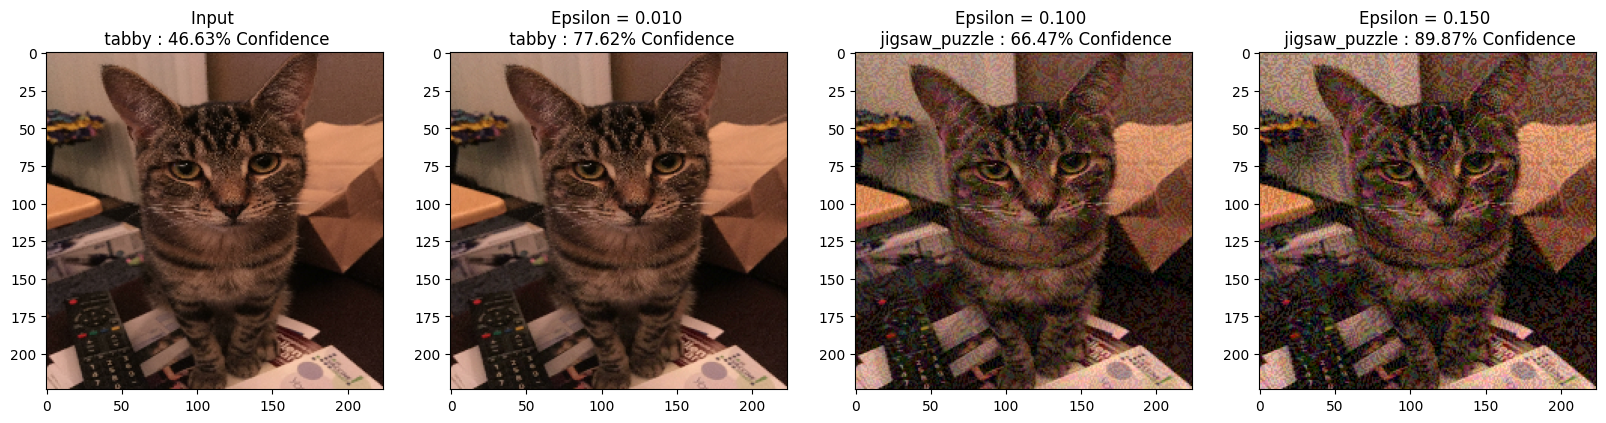

In [35]:
# FGSM-based Adversarial Images
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

plt.figure(figsize=(20, 8))
for eps in epsilons:
    # Create adversarial image using FGSM perturbations
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    # Plotting
    plt.subplot(1, len(epsilons), epsilons.index(eps) + 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    plt.imshow(adv_x[0] * 0.5 + 0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(
        descriptions[epsilons.index(eps)],
        label,
        confidence * 100
    ))

plt.show()


In [24]:
def create_advisaral_image_using_Gaussian_Noise(input_image, stddev):

    noise = tf.random.normal(shape=tf.shape(input_image), mean=0.0, stddev=stddev, dtype=input_image.dtype)
    noisy_image = input_image + noise

    noisy_image = tf.clip_by_value(noisy_image, -1, 1)

    return noisy_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


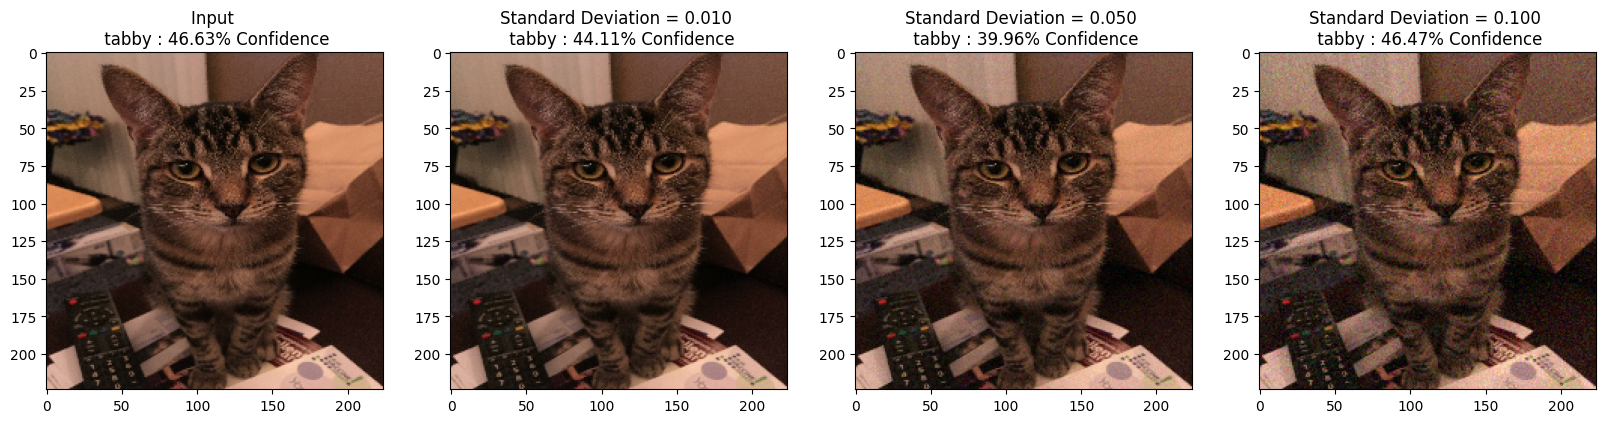

In [34]:
# Using Gaussian Noise
stddevs = [0, 0.01, 0.05, 0.1]
descriptions = [('Standard Deviation = {:0.3f}'.format(std) if std else 'Input')
                for std in stddevs]

plt.figure(figsize=(20, 8))
for std in stddevs:
    # Create adversarial image using Gaussian Noise
    adv_image = create_advisaral_image_using_Gaussian_Noise(image, stddev=std)
    plt.subplot(1, len(stddevs), stddevs.index(std) + 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_image))
    plt.imshow(adv_image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[stddevs.index(std)],
                                                    label, confidence*100))

plt.show()